In [1]:
import numpy as np
from numpy import unique, argmax
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Conv1D, MaxPool1D
import tensorflow.keras as K
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
import matplotlib.pyplot as plt

import hashlib
import time

import random

In [93]:
def generate_ephemeral_id(seed):
    data = f"{seed}{time.time()}".encode('utf-8')
    hash_object = hashlib.sha256(data)
    ephemeral_id = hash_object.hexdigest()
    return ephemeral_id


def string_to_uint32_array(id):
    flat_array = [int(id[i:i+1], 16) for i in range(0, len(id), 1)]
    array_2d = np.array(flat_array).reshape(8, 8)
    return array_2d

In [94]:
def generate_data(size: int, seeds):
  data = np.empty([size, 8, 8], dtype=np.uint32)
  labels = np.empty([size, 1], dtype=np.ubyte)

  for data_index in range(size):
    device_number = random.randint(0, len(seeds)-1)
    labels[data_index] = device_number
    ephemeral_id = generate_ephemeral_id(seeds[device_number])
    data[data_index] = string_to_uint32_array(ephemeral_id)

  return (data, labels)

In [95]:
SEEDS = ["Device0", "Device1", "Device2", "Device3"]

NUM_TRAIN_DATA = 2000
NUM_VAL_DATA = 300
NUM_TEST_DATA = 100

training_data, training_labels = generate_data(NUM_TRAIN_DATA, SEEDS)
validation_data, validation_labels = generate_data(NUM_VAL_DATA, SEEDS)
test_data, test_labels = generate_data(NUM_TEST_DATA, SEEDS)

In [96]:
training_data = np.reshape(training_data, (training_data.shape[0], training_data.shape[1], training_data.shape[2], 1))
validation_data = np.reshape(validation_data, (validation_data.shape[0], validation_data.shape[1], validation_data.shape[2], 1))
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], test_data.shape[2], 1))

print("Size of training data is ", np.shape(training_data))
print("Size of validation data is ", np.shape(validation_data))
print("Size of test data is ", np.shape(test_data))

Size of training data is  (2000, 8, 8, 1)
Size of validation data is  (300, 8, 8, 1)
Size of test data is  (100, 8, 8, 1)


In [97]:
model = Sequential([
    Conv2D(6, (3, 3), activation='relu', input_shape=training_data.shape[1:]),
    MaxPool2D(2, 2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(len(SEEDS), activation='softmax')
])

model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_2 = model.fit(training_data, training_labels, validation_data=(validation_data, validation_labels), batch_size=10, epochs=10)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 6, 6, 6)           60        
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 3, 3, 6)           0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 54)                0         
                                                                 
 dense_6 (Dense)             (None, 50)                2750      
                                                                 
 dense_7 (Dense)             (None, 4)                 204       
                                                                 
Total params: 3014 (11.77 KB)
Trainable params: 3014 (11.77 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

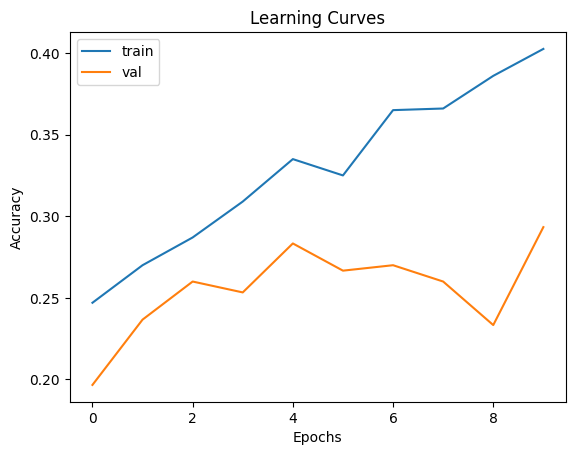

In [98]:
# ploting the learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy')
pyplot.plot(history_2.history['accuracy'], label='train')
pyplot.plot(history_2.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.show()

In [99]:
# evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels, verbose=0)
print(f'Accuracy: {accuracy*100}')

Accuracy: 27.000001072883606


In [ ]:
for index in range(len(test_data)):
  prediction = model.predict([np.expand_dims(test_data[index], axis=0)], verbose = 0)
  print('Predicted label: {} - Actual label: {}'.format(argmax(prediction), test_labels[index]))

In [ ]:
pip install tinymlgen

In [101]:
from tinymlgen import port

c_code = port(model, variable_name='model', pretty_print=True,optimize=False)
filename = 'net.h'
with open(filename,'w') as f:
    f.write(c_code)

In [91]:
test_data[0].flatten()

array([ 9.,  0.,  2., 10.,  2.,  6., 10., 14., 11.,  0.,  1.,  1.,  5.,
        5., 10., 14.,  9., 10.,  4., 12., 10., 13.,  2.,  5.,  9., 15.,
       10.,  5.,  9.,  2., 11.,  1.,  3.,  7., 15., 14.,  1.,  0., 10.,
       12.,  1.,  0., 11.,  0., 10.,  3., 13.,  9., 13.,  9., 13.,  6.,
       12.,  7., 11., 11., 13.,  9.,  8.,  6., 12.,  8.,  5.,  1.],
      dtype=float32)